# Project 1 - INDONESIA AI
## Face Recognition (Gender Classification)


#Lily Silva Ardiani
## ADA LOVELACE Group Indonesia AI Computer Vision Bootcamp 2

## ResNet

* Transfer Learning : ResNet 101
* Layer ResNet 101: Unfreeze 5 last layers
* Fully Connected Layer :
    * Flatten-Dense(512)-Dropout(0.2)-Dense(256)-Dropout(0.2)-Dense(64)-Dropout(0.2)-Dense(32)-Dropout(0.2)-Dense(2)
    * Activation relu & softmax
* Learning Rate : 0.0001
* Batch Size : 32
* Epoch : 10
* Optimizer : Adam
* Loss : Sparse Categorical Crossentropy

## Tahapan Analysis untuk Model Terbaik

1. Data Preparation
    * 1.1. Loading Library
    * 1.2. Loading Dataset Images dan List of Attributes
    * 1.3. Showing Images Examples
    * 1.4. Preparing List of Attributes with Images Attributes
    * 1.5. Showing Images with Gender
    * 1.6. Calculating Images of Male vs Female
    * 1.7. Balancing Total Images of Male vs Female
2. Data Splitting
    * 2.1. Spliting Data: Train, Test and Validation
    * 2.2. Data Augmentation for Data Train and Validation
3. Data Modelling (Transfer Learning)
    * 3.1. Data Modelling and Training
        * 3.1.1. Transfer Learning with ResNet101
        * 3.1.2. Building Architecture: Fully Connected Layer
        * 3.1.3. Model and Hyperparameter Tuning Compilation
        * 3.1.4. Model Training
    * 3.2. Validation Curves
4. Prediction and Testing The Model
    * 4.1. Data Testing Prediction
        * 4.1.1. Comparing Actual Label vs Prediction in Data Frame
        * 4.1.2. Showing Image Results Prediction
    * 4.2. Confusion Matrix
    * 4.3. Evaluation Matrix
    * 4.4. Showing Wrong Image Prediction of Male
    * 4.5. Showing Wrong Image Prediction of Female
5. Save Model
6. Reference

# 1. Data Preparation
## 1.1. Loading Library

In [1]:
 import zipfile

 zip_path = '/content/Dataset-20230715T113012Z-001.zip'
 destination_folder = '/content/Dataset'

 with zipfile.ZipFile(zip_path, 'r') as zip_ref:
     zip_ref.extractall()

In [2]:
 !pip install tensorflow

In [3]:
# Load Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import glob
import hashlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import keras
from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Code Modif dari Kaggle

## 1.2. Loading Dataset Images and List of Atrributes


In [4]:
# Directory Dataset
BASIC_PATH = '/content/Dataset'
IMG_PATH = os.path.join(BASIC_PATH,'/content/Dataset/Images')
FEATURE_PATH = os.path.join(BASIC_PATH, '/content/Dataset/image_attributes_filtered.csv')

# Code Modif dari Kaggle

In [5]:
# Calculating Total Images
n_images = len(os.listdir(IMG_PATH))
print('Total Foto dalam Dataset :', n_images, "Foto")

# Code Modif dari Kaggle

Total Foto dalam Dataset : 5017 Foto


## 1.3. Showing Images Examples
Showing 10 images from DImages Dataset

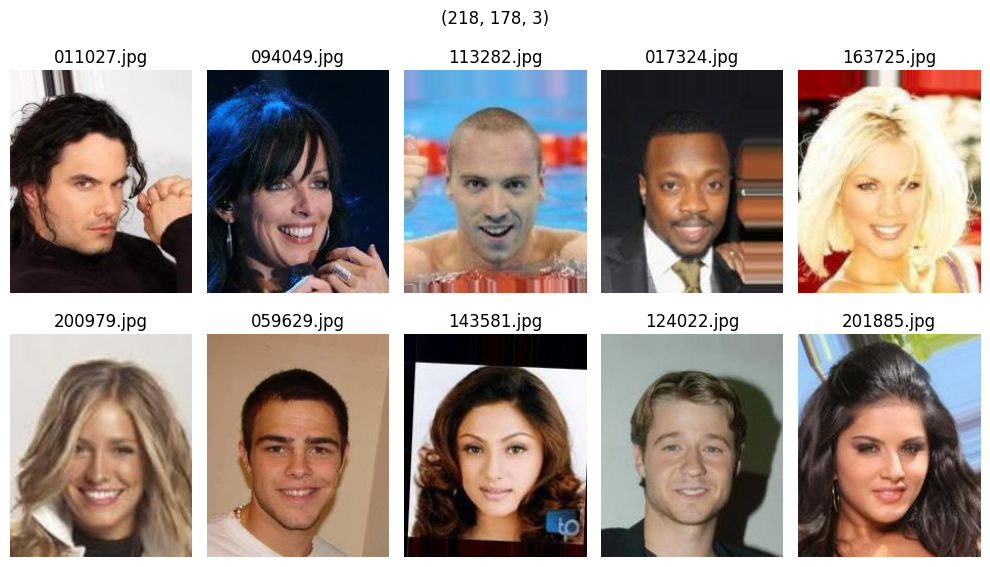

In [6]:
# Menampilkan 10 Foto

# Memperoleh List of Image dari Direktori
image_list = os.listdir(IMG_PATH)

# Membuat suatu subplot dengan 2 baris dan 5 kolom
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 6))

# Menginterasi 10 file pertama dan membuat axis subplot
for i, (image_file, ax) in enumerate(zip(image_list[:10], axes.flatten())):

    # Membaca Image dan Memplot Image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Setting Judul Plot dari Nama File
    title = image_file
    ax.set_title(title)

    # Menampilkan Dimensi Foto sebagai Suptitle
    plt.suptitle(image.shape)

    # Menonaktifkan axis ticks dan labels
    ax.axis('off')

# Mengatur spasi antar subplots
plt.tight_layout()

# Menampilkan Figure
plt.show()

# Code Modif dari Chat GPT

**Note :**
Foto berdimensi 218 x 178 pixel x 3 channel, nama file berisi Id Foto

## 1.4. Preparing List of Attributes with Images Attributes
### 1.4.1. Screening for image duplicates

Contoh file duplikat:
182912.jpg
182912(1).jpg
182809.jpg
182809(1).jpg
189132.jpg
189132(1).jpg
189512(1).jpg
189512.jpg
Total file duplikat: 17


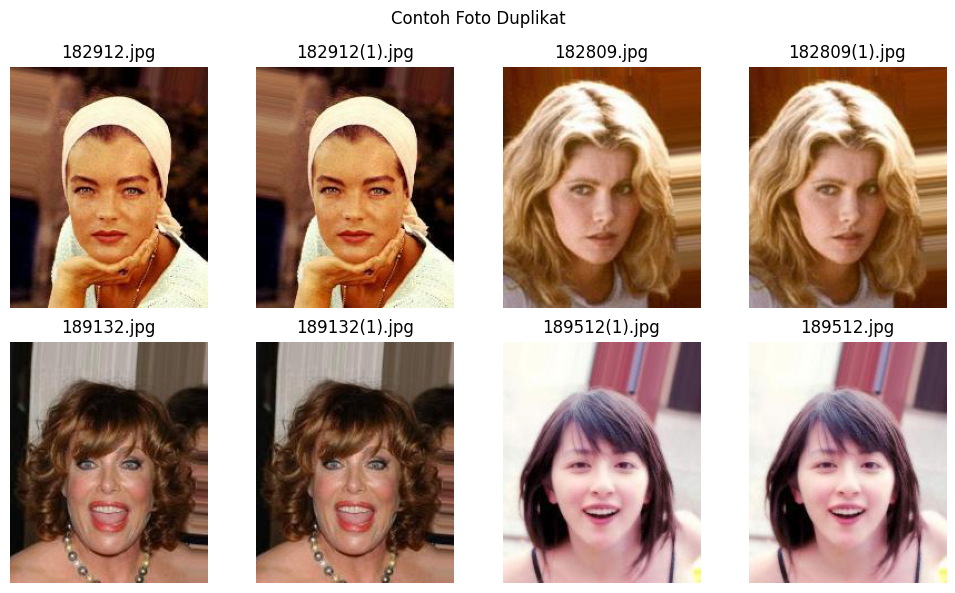

In [7]:
# Mengecek File Duplikat, Menghitung Jumlahnya dan Menampilkan 5 File Contoh

# Library yang digunakan : os dan hashlib

# Mencari semua file dengan ekstensi gambar dalam folder
image_files = [file for file in os.listdir(IMG_PATH) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Menggunakan dictionary untuk menyimpan hash nilai dan daftar file dengan hash yang sama
duplicate_files = {}

# Memeriksa setiap file gambar
for file_name in image_files:
    file_path = os.path.join(IMG_PATH, file_name)
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    if file_hash not in duplicate_files:
        duplicate_files[file_hash] = [file_name]
    else:
        duplicate_files[file_hash].append(file_name)

# Menghitung total file yang duplikat
total_duplicate_files = sum(len(files) - 1 for files in duplicate_files.values())

# Menampilkan 8 contoh nama file yang duplikat
print("Contoh file duplikat:")
count = 0
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        for file_name in file_list[:8]:
            count += 1
            print(file_name)
            if count == 8:
                break
    if count == 8:
        break

# Menampilkan total file yang duplikat
print(f"Total file duplikat: {total_duplicate_files}")

# Mengumpulkan 8 contoh file duplikat
duplicate_examples = []
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        duplicate_examples.extend(file_list[:8])
    if len(duplicate_examples) >= 10:
        break

# Menampilkan 8 foto duplikat dengan judul sebagai nama file
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(duplicate_examples):
        file_name = duplicate_examples[i]
        file_path = os.path.join(IMG_PATH, file_name)
        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_title(file_name)
        plt.suptitle('Contoh Foto Duplikat')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

### 1.4.2. Showing Image Filename list

In [8]:
# Membuat List Nama File Foto untuk Join dengan Nama File pada File list_attribute.csv

# Library yang digunakan : glob dan pandas

# Tentukan pola nama file foto (misal: JPEG, PNG)
file_ekstensi = '*.jpg' # Ganti dengan ekstensi file gambar yang sesuai

# Tentukan direktori tempat file-file gambar berada
direktori_foto = IMG_PATH

# Mendapatkan list nama file
nama_file = glob.glob(direktori_foto + '/' + file_ekstensi)

# List nama file dijadikan dataframe
data = pd.DataFrame(nama_file, columns = ['image_id'])

# Menampilkan dataframe
data.head()

# Code Modif dari Chat GPT

image_id
0  /content/Dataset/Images/011027.jpg
1  /content/Dataset/Images/094049.jpg
2  /content/Dataset/Images/113282.jpg
3  /content/Dataset/Images/017324.jpg
4  /content/Dataset/Images/163725.jpg

### 1.4.3. Cleaning Image Filename list

In [9]:
# Membuang karakter pertama hingga sebelum nama file
data['image_id'] = data['image_id'].str.split('/').str[-1]
data.head()

# Code Modif dari Googling

image_id
0  011027.jpg
1  094049.jpg
2  113282.jpg
3  017324.jpg
4  163725.jpg

In [10]:
data.shape

(5017, 1)

### 1.4.4. Loading Attribute Dataset from image_attributes_filtered.csv



In [11]:
# Load Dataset 'image_list_attribute.csv'
df_attribute = pd.read_csv(FEATURE_PATH)
df_attribute.head()

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000051.jpg                 1  ...               -1     -1
1  000052.jpg                -1  ...               -1     -1
2  000065.jpg                -1  ...               -1      1
3  000166.jpg                 1  ...               -1     -1
4  000198.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [12]:
# Cek Informasi pada DataFrame
df_attribute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             5000 non-null   object
 1   5_o_Clock_Shadow     5000 non-null   int64 
 2   Arched_Eyebrows      5000 non-null   int64 
 3   Attractive           5000 non-null   int64 
 4   Bags_Under_Eyes      5000 non-null   int64 
 5   Bald                 5000 non-null   int64 
 6   Bangs                5000 non-null   int64 
 7   Big_Lips             5000 non-null   int64 
 8   Big_Nose             5000 non-null   int64 
 9   Black_Hair           5000 non-null   int64 
 10  Blond_Hair           5000 non-null   int64 
 11  Blurry               5000 non-null   int64 
 12  Brown_Hair           5000 non-null   int64 
 13  Bushy_Eyebrows       5000 non-null   int64 
 14  Chubby               5000 non-null   int64 
 15  Double_Chin          5000 non-null   int64 
 16  Eyegla

In [13]:
#numeric=list(df_attribute.select_dtypes(include=[np.number]).columns)
#categoric=list(df_attribute.select_dtypes(include=[object]).columns)
#print(f'Numerical:\n{numeric}\n\ncolumns total:{len(numeric)}\n\nCategorical:\n{categoric}\n\ncolumns total:{len(categoric)}')

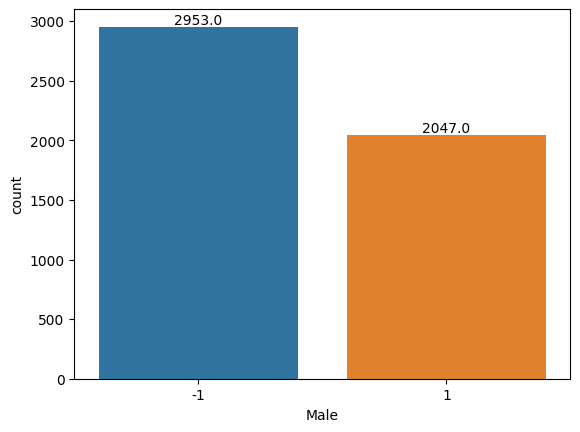

In [14]:
import seaborn as sns

ax = sns.countplot(x='Male',data=df_attribute)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

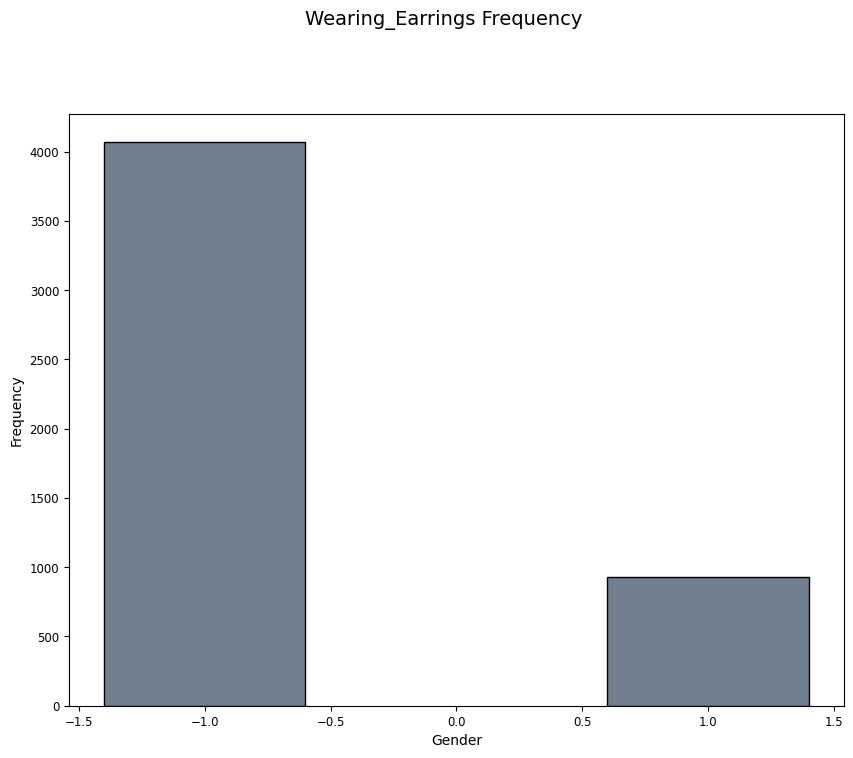

In [15]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Wearing_Earrings Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Wearing_Earrings'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='slategrey',
        edgecolor='black', linewidth=1)

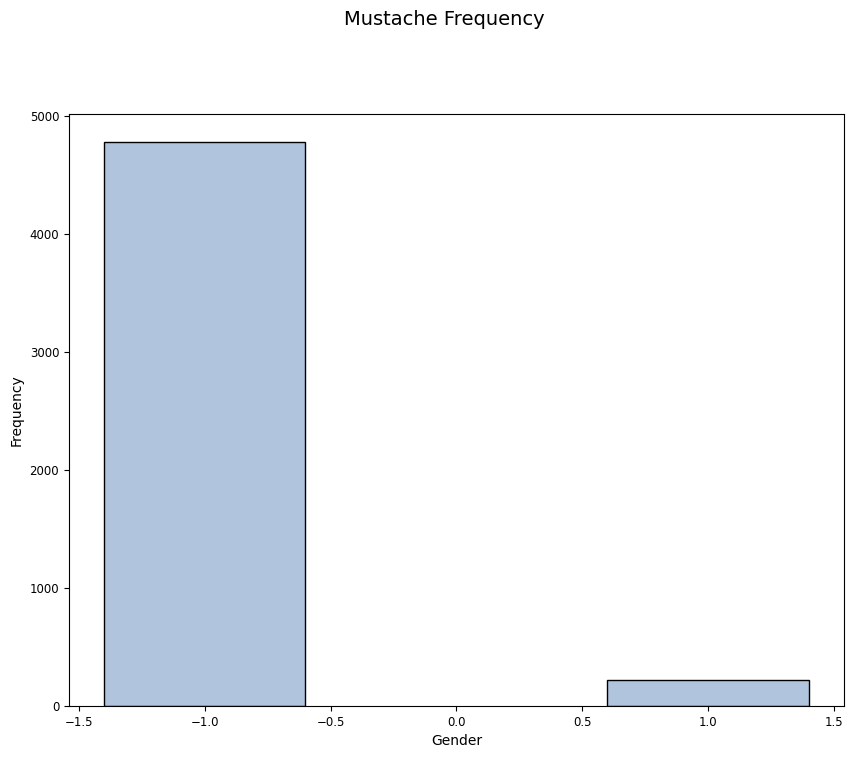

In [16]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Mustache Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Mustache'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='lightsteelblue',
        edgecolor='black', linewidth=1)

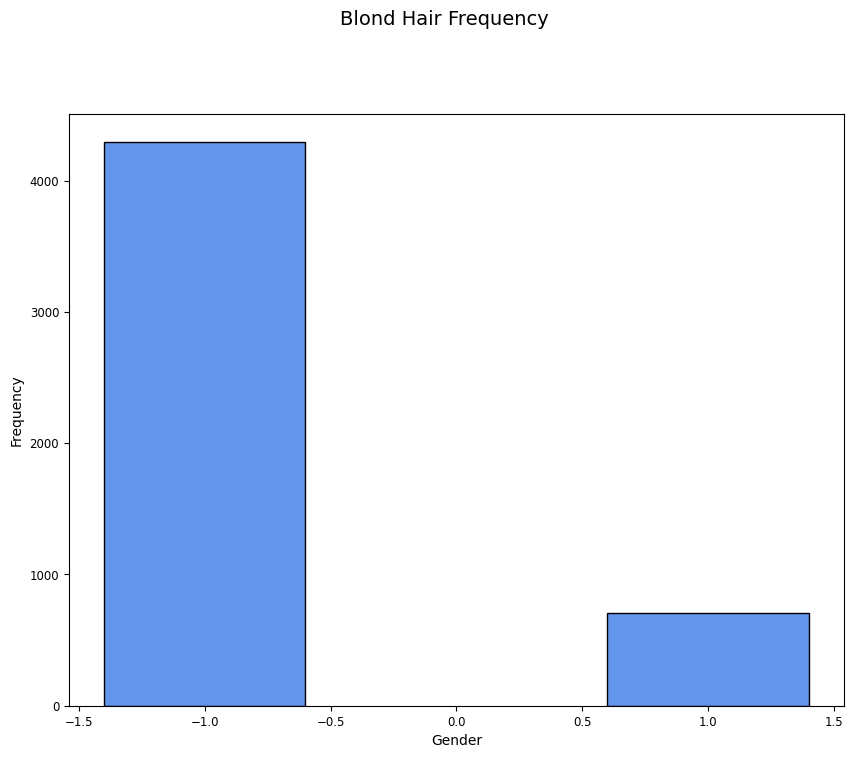

In [17]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Blond Hair Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Blond_Hair'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='cornflowerblue',
        edgecolor='black', linewidth=1)

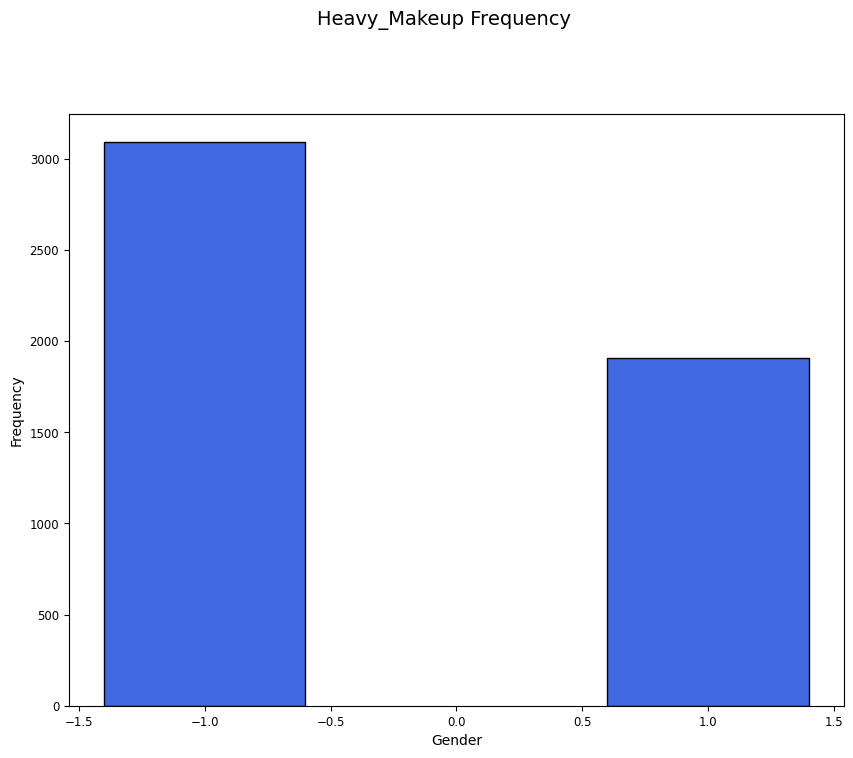

In [18]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Heavy_Makeup Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Heavy_Makeup'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='royalblue',
        edgecolor='black', linewidth=1)

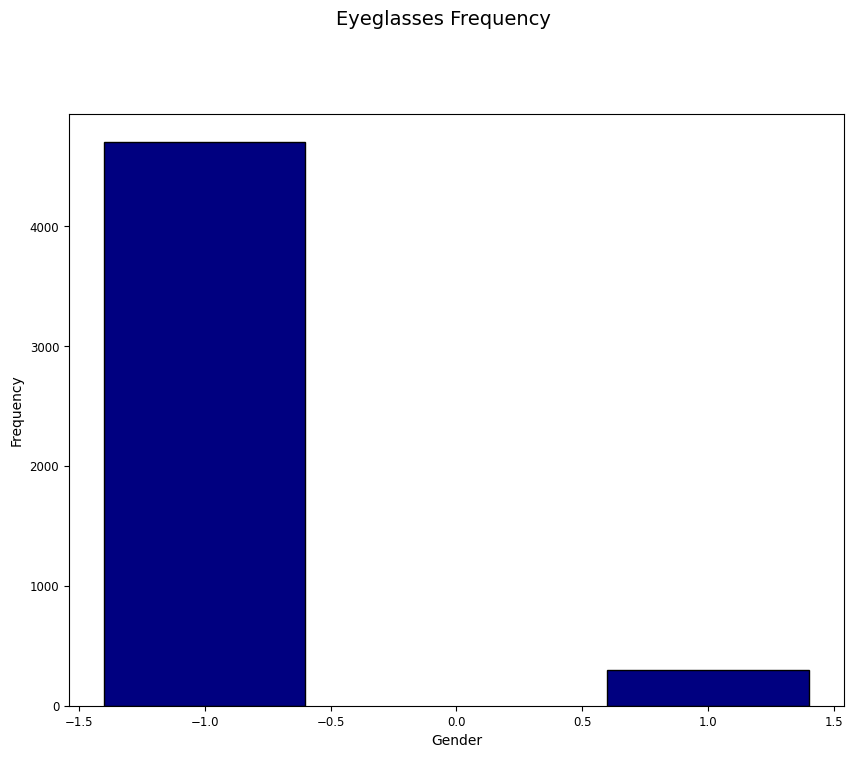

In [19]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Eyeglasses Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Eyeglasses'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='navy',
        edgecolor='black', linewidth=1)

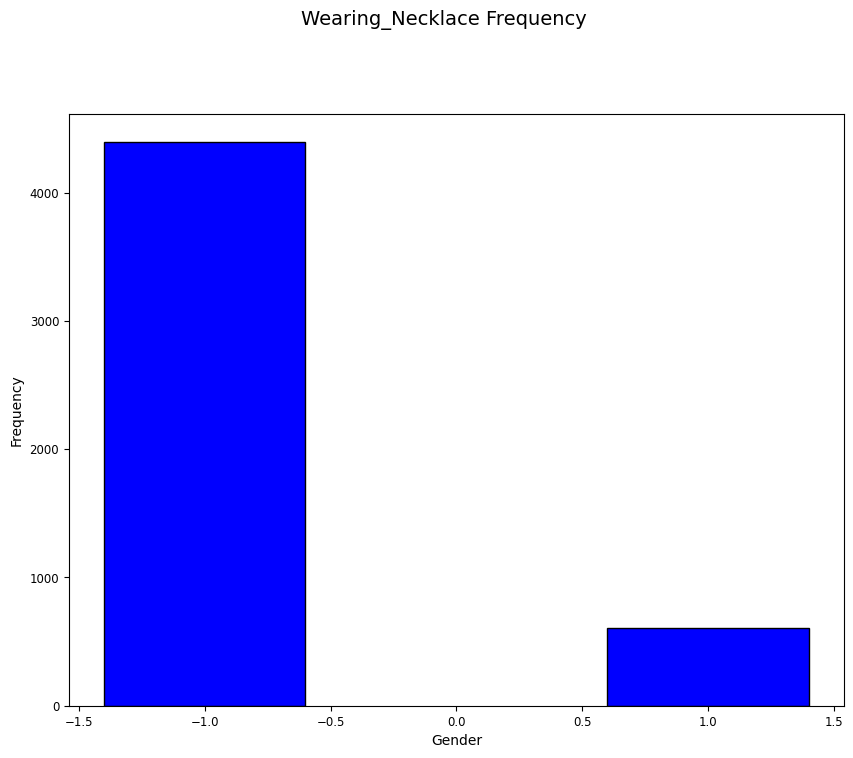

In [20]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Wearing_Necklace Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Gender")
ax.set_ylabel("Frequency")
w_q = df_attribute['Wearing_Necklace'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(w_q[0], w_q[1], color='blue',
        edgecolor='black', linewidth=1)

<ipython-input-21-6ba29cbc5f64>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_attribute['Male'])


<Axes: xlabel='Male', ylabel='Density'>

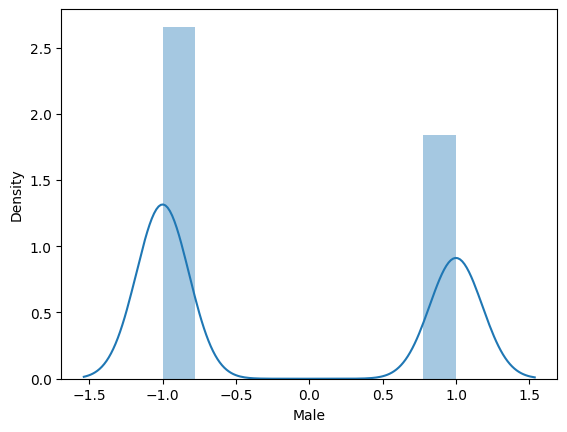

In [21]:
sns.distplot(df_attribute['Male'])

In [22]:
df_attribute.describe()

5_o_Clock_Shadow  Arched_Eyebrows  ...  Wearing_Necktie      Young
count       5000.000000       5000.00000  ...      5000.000000  5000.0000
mean          -0.785200         -0.46920  ...        -0.858800     0.5552
std            0.619304          0.88318  ...         0.512362     0.8318
min           -1.000000         -1.00000  ...        -1.000000    -1.0000
25%           -1.000000         -1.00000  ...        -1.000000     1.0000
50%           -1.000000         -1.00000  ...        -1.000000     1.0000
75%           -1.000000          1.00000  ...        -1.000000     1.0000
max            1.000000          1.00000  ...         1.000000     1.0000

[8 rows x 40 columns]

<ipython-input-23-59165175b240>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_attribute.corr()


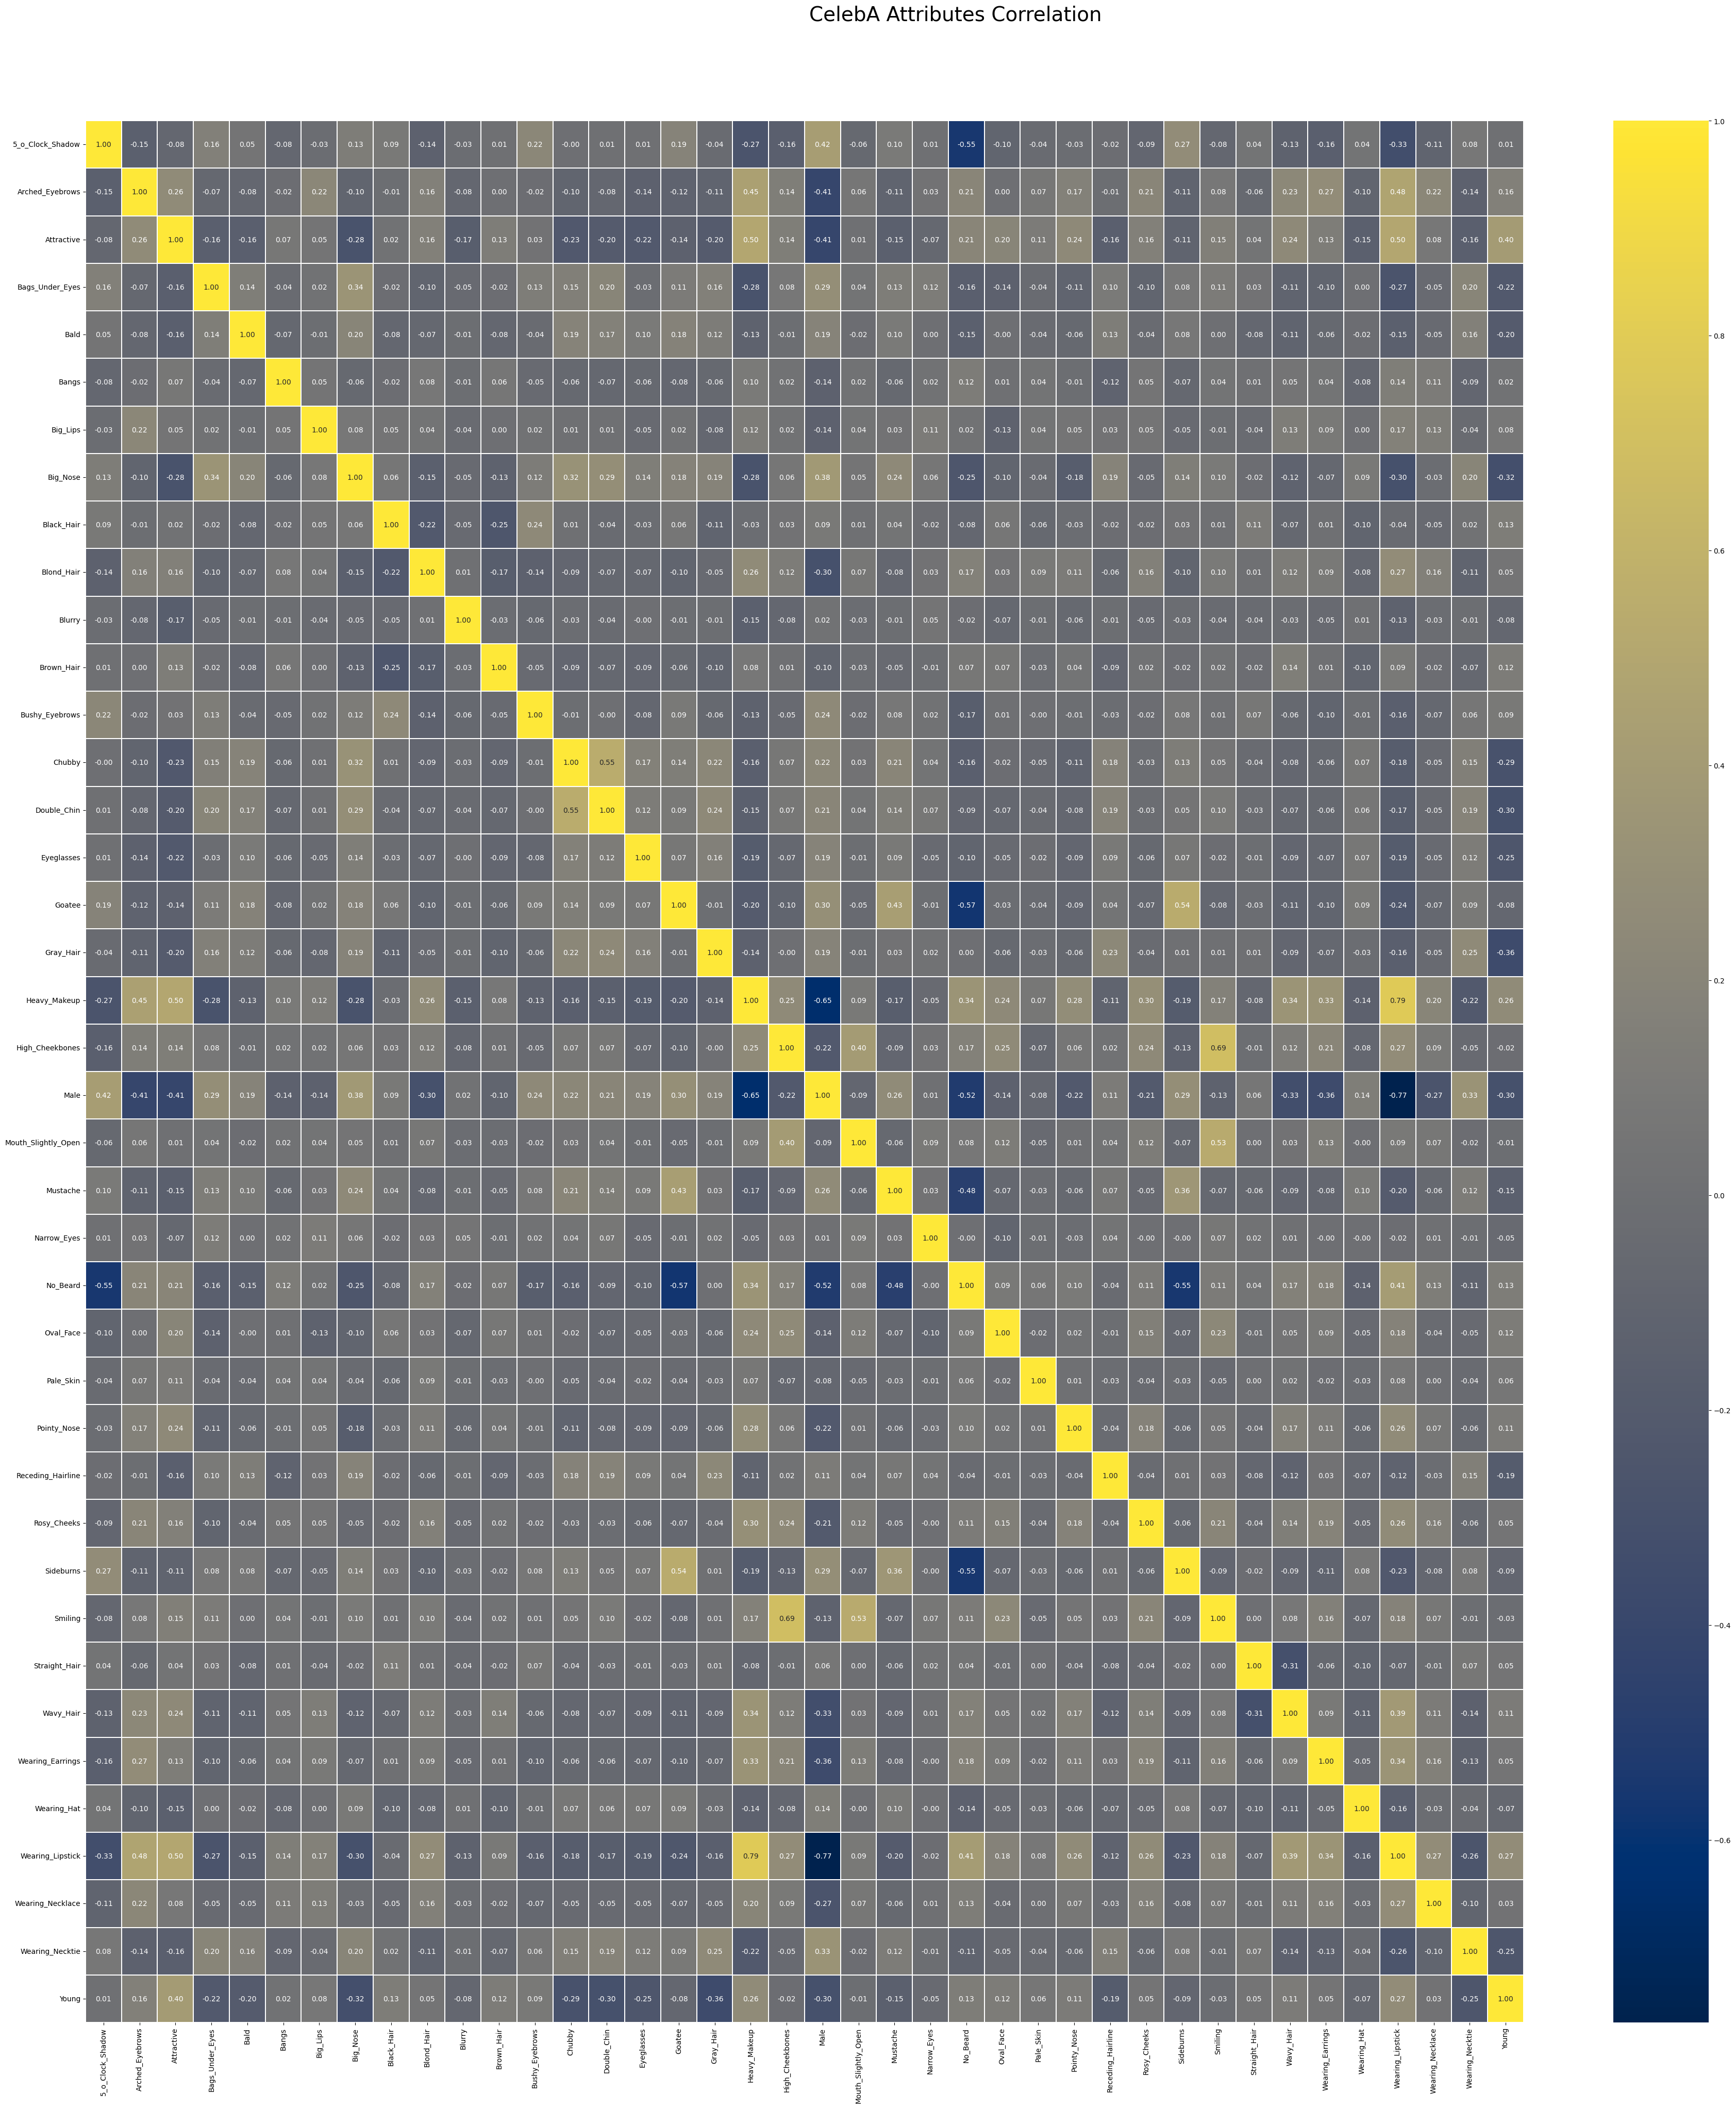

In [23]:
import seaborn as sns
f, ax = plt.subplots(figsize=(45,45))
corr = df_attribute.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="cividis",fmt='.2f',
                 linewidths=.01)
f.subplots_adjust(top=0.93)
t= f.suptitle('CelebA Attributes Correlation', fontsize=28)

In [24]:
corr = df_attribute.corr()
print(corr['Male'].sort_values(ascending=True))

Wearing_Lipstick      -0.773946
Heavy_Makeup          -0.651239
No_Beard              -0.519577
Arched_Eyebrows       -0.413851
Attractive            -0.409725
Wearing_Earrings      -0.364263
Wavy_Hair             -0.331015
Blond_Hair            -0.301389
Young                 -0.299038
Wearing_Necklace      -0.267749
Pointy_Nose           -0.222557
High_Cheekbones       -0.218558
Rosy_Cheeks           -0.205316
Big_Lips              -0.141357
Oval_Face             -0.141160
Bangs                 -0.137730
Smiling               -0.129694
Brown_Hair            -0.104350
Mouth_Slightly_Open   -0.094140
Pale_Skin             -0.077384
Narrow_Eyes            0.009517
Blurry                 0.020473
Straight_Hair          0.061667
Black_Hair             0.093071
Receding_Hairline      0.111225
Wearing_Hat            0.138209
Gray_Hair              0.186538
Bald                   0.189531
Eyeglasses             0.191999
Double_Chin            0.212363
Chubby                 0.221060
Bushy_Ey

<ipython-input-24-5d3caed9e2cf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_attribute.corr()


Note :

1. List nama file (kolom 'image_id') pada dataset list_attribute berbeda dengan list nama file pada foto, maka perlu dilakukan **Join Data** nama file foto dengan *list_attribute*, selain itu juga total list nama file pada *list_attribute* sebanyak 202599 baris.
2. Kolom yang perlu diambil adalah kolom `image_id` dan kolom `Male` sebagai pedoman bagi keterangan *Gender*.

### 1.4.6. Joining Data
Note :
1. Menggunakan *Inner Join*, agar yang tersisa hanya baris yang sesuai saja dengan nama file pada foto pada objek **data**.
2. Kemudian subsetting hanya kolom `image_id` dan `Male` untuk labelling selanjutnya.

In [25]:
# Inner Join antara Objek 'data' dengan Objek 'list_attribute'
df_join = pd.merge(data, df_attribute, on = 'image_id', how = 'inner')
df_join.head()

# Code Modif dari Googling

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  011027.jpg                 1  ...               -1      1
1  094049.jpg                -1  ...               -1      1
2  113282.jpg                -1  ...               -1      1
3  017324.jpg                -1  ...                1      1
4  163725.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [26]:
# Cek Jumlah Bari yang telah Join Inner
df_join.shape

(5000, 41)

### 1.4.5. Loading Gender Dataset from gender_classification.csv

In [27]:
df_gender= pd.read_csv('/content/Dataset/gender_classification.csv')
df_gender.head()

Male
0     1
1     1
2     1
3     0
4     0

In [28]:
df_gender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Male    5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


### 1.4.6. Subsetting `image_id` dan `Male` Columns and Gender Name

In [29]:
# Subsetting Kolom 'image_id' dan 'Male'
df_gender = df_join.loc[:, ['image_id', 'Male']]
df_gender.head(10)

image_id  Male
0  011027.jpg     1
1  094049.jpg    -1
2  113282.jpg     1
3  017324.jpg     1
4  163725.jpg    -1
5  200979.jpg    -1
6  059629.jpg     1
7  143581.jpg    -1
8  124022.jpg     1
9  201885.jpg    -1

In [30]:
# Menambahkan Kolom Gender untuk Nama Gender
df_gender['Gender'] = df_gender['Male'].replace([1, -1], ['Male', 'Female'])
df_gender.head(10)

# Code Modif dari Googling

image_id  Male  Gender
0  011027.jpg     1    Male
1  094049.jpg    -1  Female
2  113282.jpg     1    Male
3  017324.jpg     1    Male
4  163725.jpg    -1  Female
5  200979.jpg    -1  Female
6  059629.jpg     1    Male
7  143581.jpg    -1  Female
8  124022.jpg     1    Male
9  201885.jpg    -1  Female

In [31]:
# Cek Informasi Dataframe
df_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5000 non-null   object
 1   Male      5000 non-null   int64 
 2   Gender    5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 156.2+ KB


## 1.5. Showing Images with Gender

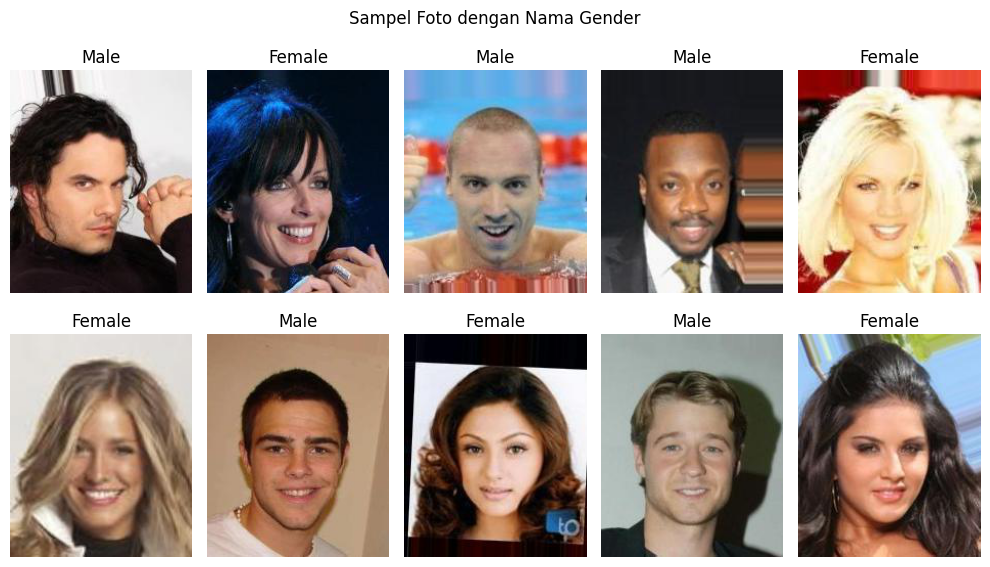

In [32]:
# Mendapatkan 10 baris pertama dari dataframe
df_subset = df_gender.head(10)

# Membuat suatu subplot dengan 2 baris dan 5 kolom
fig,axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 6))

# Mengiterasi dataframe dan axis subplot
for index, (ax, row) in enumerate(zip(axes.flatten(), df_subset.iterrows())):
    # Mendapatkan nama file gambar dan nilai yang sesuai
    image_file = row[1]['image_id']
    value = row[1]['Gender']

    # Membaca foto dan menampilkan dalam bentuk figure
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Setting judul figure dari value pada dataframe
    title = str(value)
    ax.set_title(title)
    plt.suptitle('Sampel Foto dengan Nama Gender')

    # Menonaktifkan axis ticks dan labels
    ax.axis('off')

# Mengatur spasi antar subplots
plt.tight_layout()

# Menampilkan Figure
plt.show()

# Code Modif dari Chat GPT

## 1.6. Calculating Images of Male vs Female

In [33]:
# Menghitung Jumlah Foto Male vs Female
category_count = df_gender['Gender'].value_counts()
print(category_count)

# Code Modif dari Kaggle

Female    2953
Male      2047
Name: Gender, dtype: int64


In [34]:
# Foto dengan Category Terbanyak
higher_category = list(category_count.index)[0]
print('Foto Terbanyak pada Gender: ', higher_category)

# Code Modif dari Kaggle

Foto Terbanyak pada Gender:  Female


## 1.7. Balancing Total Images of Male vs Female

In [35]:
# Mendapatkan indeks dari indeks foto higher_category
np.random.seed(42)
indices = df_gender[df_gender['Gender'] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Membuang baris ekstra foto perempuan untuk memperbaiki masalah keseimbangan data
drop_sample = np.random.choice(indices, sample_size, replace = False)
df_balance = df_gender.drop(drop_sample, axis = 'index')
df_balance

# Code Modif dari Kaggle

image_id  Male  Gender
0     011027.jpg     1    Male
1     094049.jpg    -1  Female
2     113282.jpg     1    Male
3     017324.jpg     1    Male
4     163725.jpg    -1  Female
...          ...   ...     ...
4993  159444.jpg    -1  Female
4995  057892.jpg    -1  Female
4996  032310.jpg    -1  Female
4997  139881.jpg     1    Male
4998  200160.jpg    -1  Female

[4094 rows x 3 columns]

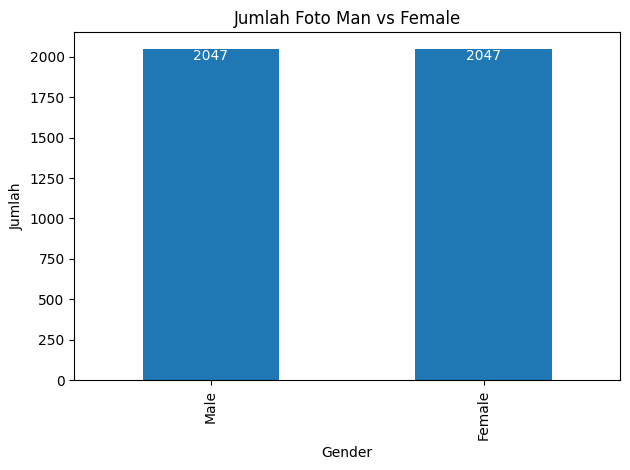

In [36]:
# Cek Kembali Jumlah Foto Man vs Female dan Visualisasikan

# Menghitung jumlah kategori "Male" vs "Female" dari kolom 'Gender'
balance_count = df_balance['Gender'].value_counts()

# Membuat bar plot dari hasil value_counts()
ax = balance_count.plot(kind='bar')

# Menampilkan nilai di atas setiap bar
for i, count in enumerate(balance_count):
    ax.text(i, count, str(count), ha='center', va='top', color = 'white')

# Memberi label sumbu x dan sumbu y
plt.title('Jumlah Foto Man vs Female')
ax.set_xlabel('Gender')
ax.set_ylabel('Jumlah')

# Menampilkan plot
plt.tight_layout()
plt.show()

# Code Modif dari Chat GPT

# 2. Data Splitting
## 2.1. Splitting Data: Train, Test and Validation

In [37]:
# Splitting Dataset
train_df, test_df = train_test_split(df_balance, test_size = 0.3)
test_df, validation_df = train_test_split(test_df, test_size=0.33)

Note :

* Data Train = 70%
* Data Test = 20%
* Data Validation = 10%

In [38]:
# Cek Jumlah Dataset per Masing-Masing Bagian
print('Total Train Sampel Images:', len(train_df))
print('Total Test Sampel Images:', len(test_df))
print('Total Validation Sampel Images:', len(validation_df))

Total Train Sampel Images: 2865
Total Test Sampel Images: 823
Total Validation Sampel Images: 406


## 2.2. Data Augmentation for Data Train and Validation

In [39]:
# Menentukan Ukuran Sampel dan Batch_Size
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 32

In [40]:
# Membuat Data Augmentasi untuk Train Image

# Membuat objek ImageDataGenerator untuk augmentasi data pada data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi intensitas piksel antara 0 dan 1
    rotation_range=15,  # Rentang rotasi gambar antara -40 derajat hingga +40 derajat
    width_shift_range=0.1,  # Rentang pergeseran horizontal gambar
    height_shift_range=0.1,  # Rentang pergeseran vertikal gambar
    shear_range=0.1,  # Rentang pergeseran sisi gambar
    zoom_range=0.2,  # Rentang perbesaran gambar
    horizontal_flip=True  # Membalik gambar secara horizontal
    #fill_mode='nearest'  # Metode pengisian piksel yang hilang
)

# Memuat gambar dan melakukan augmentasi pada data pelatihan
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_PATH + "/",
    x_col = 'image_id',
    y_col = 'Gender',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

# Code Modif from Chat GPT & Kaggle

Found 2865 validated image filenames belonging to 2 classes.


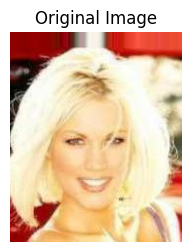

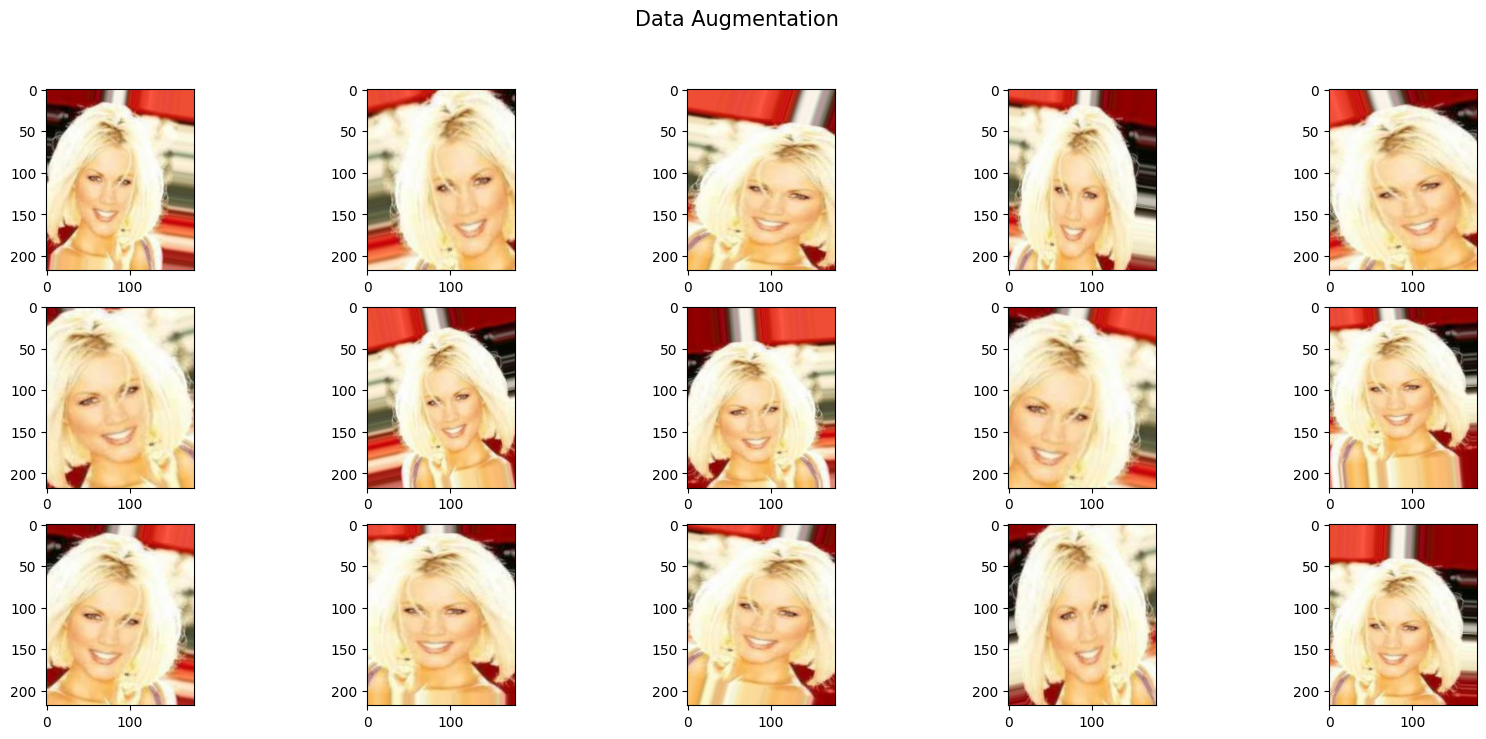

In [41]:
from tensorflow.keras.preprocessing.image import img_to_array
# Demonstrating Data Augmentation

# Membaca foto dari folder
image_path = os.path.join(IMG_PATH, '163725.jpg')  # Ganti 'nama_file.jpg' dengan nama file yang sesuai
original_image = plt.imread(image_path)

# Menampilkan foto asli
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Loading example image
img = original_image
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

# Plotting Data Augmentation based on example image
plt.figure(figsize = (20, 8))
plt.suptitle('Data Augmentation', fontsize = 15)

i = 0
for batch in train_datagen.flow(x, batch_size = 1):
    plt.subplot(3, 5, i + 1)
    plt.grid = (False)
    plt.imshow(batch.reshape(218, 178, 3))

    if i == 14:
        break
    i += 1

plt.show()

# Code Modif dari Kaggle

In [42]:
# Normalisasi untuk Validation Image

# Membuat objek ImageDataGenerator untuk normalisasi data pada data validasi
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Memuat gambar dan melakukan normalisasi pada data validasi
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    IMG_PATH + "/",
    x_col = 'image_id',
    y_col = 'Gender',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

# Code Modif from Kaggle

Found 406 validated image filenames belonging to 2 classes.


In [43]:
# Normalisasi untuk Testing Image

# Membuat objek ImageDataGenerator untuk normalisasi data pada data testing
test_datagen = ImageDataGenerator(rescale = 1./255)

# Memuat gambar dan melakukan normalisasi pada data testing
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    IMG_PATH + "/",
    x_col = 'image_id',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

# Code Modif from Kaggle

Found 823 validated image filenames.


# 3. Data Modelling (Transfer Learning)
## 3.1. Data Modelling and Training

### 3.1.1. Transfer Learning with ResNet 101

In [44]:
# Transfer Learning dengan ResNet101
from tensorflow.keras.applications import ResNet101

base_resnet_model = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape= IMAGE_SIZE + (3,)
)

# Code Modif from Kaggle

171446536/171446536 [==============================] - 6s 0us/step


In [45]:
# Melihat Arsitektur ResNet 101
for layer in base_resnet_model.layers[-5:]: # Unfreeze 5 layer terakhir
    layer.trainable = True
base_resnet_model.summary()
# Code Modif from Kaggle & Chat GPT

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 224, 184, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 109, 89, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 109, 89, 64)  256         ['conv1_conv[0][0]']     

### 3.1.2. Building Architecture: Fully Connected Layer

In [46]:
# Membuat Arsitektur Fully Connected
resnet_model = Sequential(
    [
    base_resnet_model,
    Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation="softmax")
]
)
# Code Modif from Kaggle

In [47]:
# Menampilkan Arsitektur Deep Learning yang Akan Digunakan
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 6, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 dense (Dense)               (None, 512)               44040704  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1

### 3.1.3. Model and Hyperparameter Tuning Compilation

In [48]:
# Kompile Model Deep Learning
base_learning_rate = 0.0001
resnet_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [49]:
# Early Stopping dan Learning Rate Reduction

#Load Library
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
checkpointer = ModelCheckpoint(filepath='resnet101_lily.h5',
                               verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=4,
                                           verbose=1,
                                           factor=0.5,
                                           min_learning_rate=0.001,
                                            )
callbacks = [earlystop, learning_rate_reduction, checkpointer]

# Code Modif from Kaggle

In [50]:
# Model Architecture
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 6, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 86016)             0         
                                                                 
 dense (Dense)               (None, 512)               44040704  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1

### 3.1.4. Model Training

In [51]:
# Mengukur waktu pelatihan model
import time
start_time = time.time()

# Run Model Training
history = resnet_model.fit(train_generator,
                        validation_data = validation_generator,
                        validation_steps = len(validation_df)//BATCH_SIZE,
                        steps_per_epoch = len(train_df)//BATCH_SIZE,
                        epochs = 10,
                        verbose = 1,
                        callbacks = callbacks)

# Menghitung waktu pelatihan
training_time = time.time() - start_time
print("Total training time: {:.2f} seconds".format(training_time))

# Code Modif from Chat GPT & Kaggle

Epoch 1/10
89/89 [==============================] - ETA: 0s - loss: 0.4341 - accuracy: 0.8179
Epoch 1: val_loss improved from inf to 12.52776, saving model to resnet101_lily.h5
89/89 [==============================] - 150s 684ms/step - loss: 0.4341 - accuracy: 0.8179 - val_loss: 12.5278 - val_accuracy: 0.5078 - lr: 1.0000e-04
Epoch 2/10
89/89 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9255
Epoch 2: val_loss improved from 12.52776 to 2.30306, saving model to resnet101_lily.h5
89/89 [==============================] - 55s 617ms/step - loss: 0.1871 - accuracy: 0.9255 - val_loss: 2.3031 - val_accuracy: 0.5026 - lr: 1.0000e-04
Epoch 3/10
89/89 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9481
Epoch 3: val_loss did not improve from 2.30306
89/89 [==============================] - 48s 538ms/step - loss: 0.1464 - accuracy: 0.9481 - val_loss: 2.4792 - val_accuracy: 0.4844 - lr: 1.0000e-04
Epoch 4/10
89/89 [==============================] - 

In [52]:
# Print Waktu Training dalam Jam
print("Total training time: {:.2f} hours".format(training_time/3600))

Total training time: 0.21 hours


## 3.2. Validation Curves

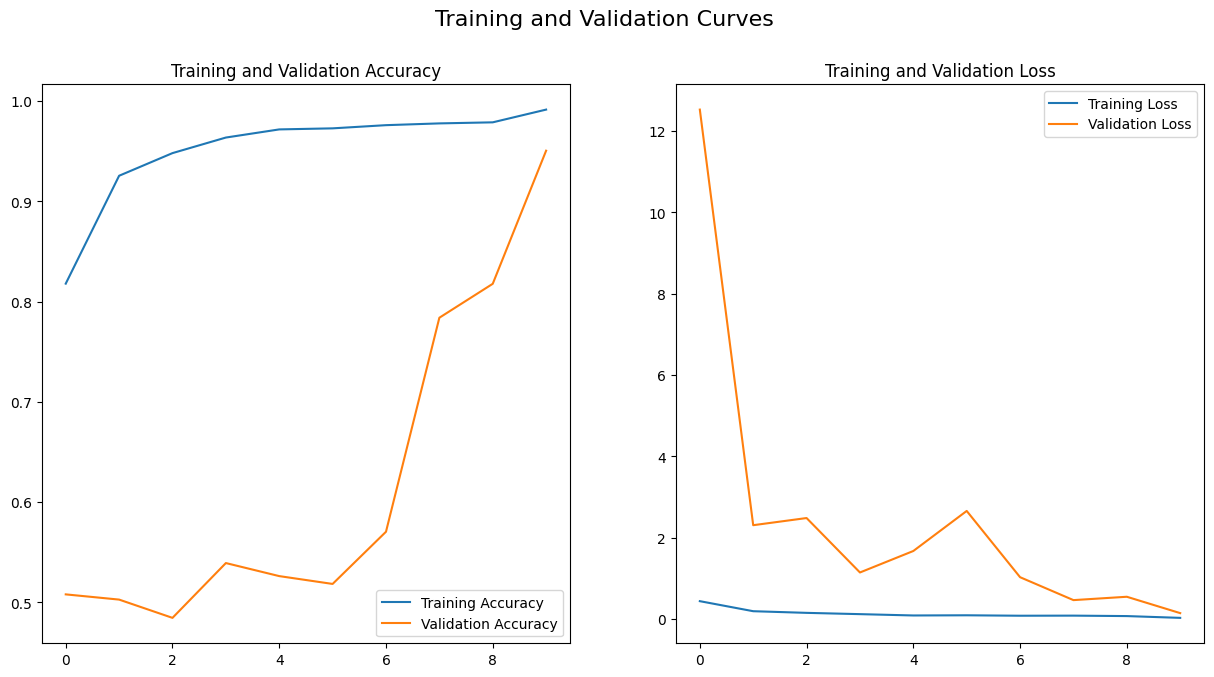

In [53]:
# Evaluasi Hasil Training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10) # Cek untuk di sesuaikan

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.suptitle('Training and Validation Curves', size = 16)
plt.subplots_adjust(top=0.93) # Mengatur jarak vertikal antara judul figure dan judul subplot
plt.savefig('./Validation_Curves_Experiment_2.jpg',
            dpi = 150, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Code Modif from previous workshop


In [54]:
# Evaluasi Model

print("Validation Akurasi")
print("Maksimum akurasi:  %.2f" % (np.max(val_acc)*100), "%")
print("Rata-rata akurasi:  %.2f" % (np.mean(val_acc)*100), "%")
print("Standar deviasi akurasi: %.2f" % np.std(val_acc))

print("")

print('Validation Loss')
print("Minimun loss:  %.2f" % (np.min(val_loss)*100), "%")
print("Rata-rata loss:  %.2f" % (np.mean(val_loss)*100), "%")
print("Standar deviasi loss: %.2f" % np.std(val_loss))

Validation Akurasi
Maksimum akurasi:  95.05 %
Rata-rata akurasi:  62.01 %
Standar deviasi akurasi: 0.16

Validation Loss
Minimun loss:  13.99 %
Rata-rata loss:  249.38 %
Standar deviasi loss: 3.45


# 4. Prediction and Testing The Model
## 4.1. Data Testing Prediction

In [55]:
# Mengevaluasi ResNet101 Model pada Data test_generator
resnet_model.evaluate(test_generator)

26/26 [==============================] - 4s 86ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [56]:
# Melakukan Prediksi pada Dataset test_generator
BATCH_SIZE_TRAIN = 32
predict = resnet_model.predict(test_generator, steps = np.ceil(len(test_df)/BATCH_SIZE_TRAIN))

26/26 [==============================] - 6s 177ms/step


### 4.1.1. Comparing Actual Label vs Prediction in Data Frame

In [57]:
# Membandingkan Antara Aktual vs Prediksi
prediction = predict.argmax(axis = -1)
test_df['Prediction'] = ['Male' if ele == 1 else 'Female' for ele in prediction]

# Cek Aktual vs Validation
test_df.head(10)

image_id  Male  Gender Prediction
1360  084268.jpg     1    Male       Male
2104  135052.jpg     1    Male       Male
3987  184206.jpg     1    Male       Male
3815  108937.jpg    -1  Female     Female
4165  045553.jpg    -1  Female     Female
488   134768.jpg     1    Male       Male
3735  032541.jpg    -1  Female     Female
2527  173588.jpg    -1  Female     Female
655   064011.jpg     1    Male       Male
4841  115131.jpg    -1  Female     Female

### 4.1.2. Showing Image Results Prediction

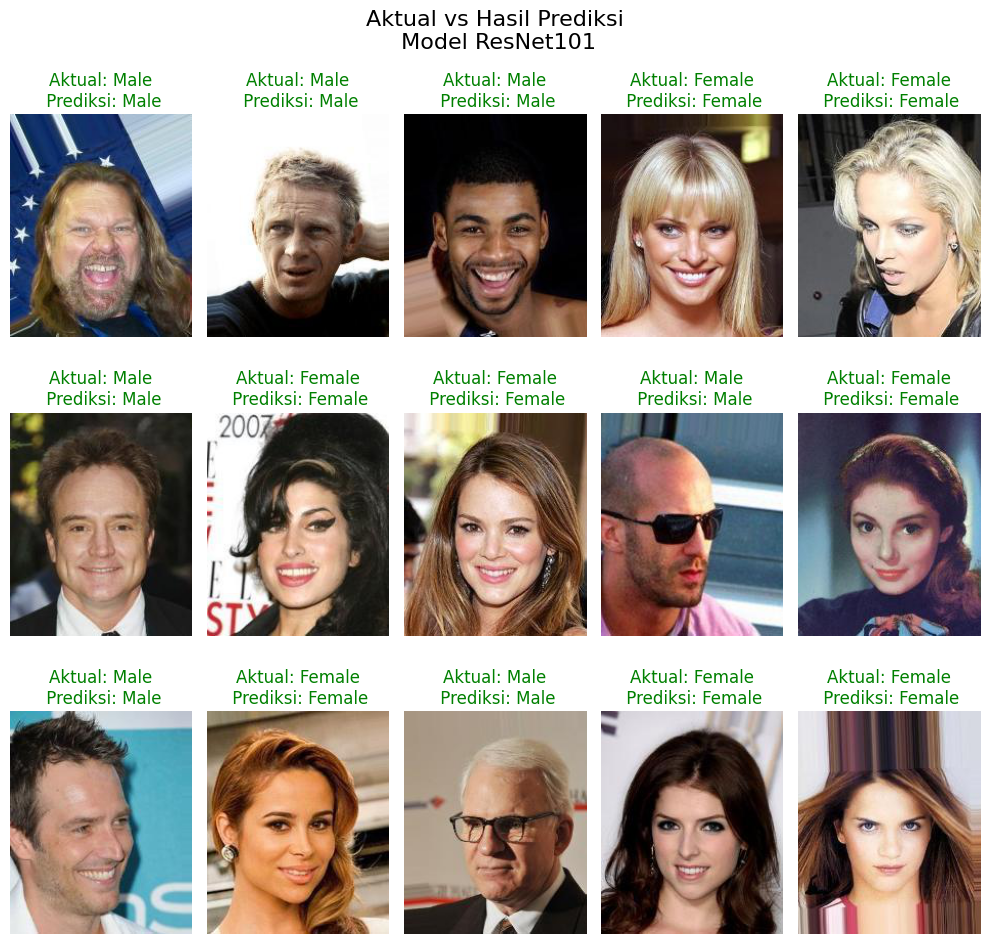

In [58]:
# Menampilkan Foto Beserta Label Gender dan Hasil Prediksi

# Get the first 10 rows from the data frame
df_test_subset = test_df.head(15)

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), df_test_subset.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']

    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Aktual vs Hasil Prediksi\n Model ResNet101", size = 16)

    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('./Foto_Aktual_vs_Prediksi_ResNet101_Experiment.jpg', dpi=150)

# Code Modif dari Chat GPT

## 4.2. Confusion Matrix

In [59]:
# Mengkalkulasi Confusion Matrix
labels = ['Male', 'Female']

cm = confusion_matrix(test_df['Gender'], test_df['Prediction'], labels = labels)
cm

array([[426,  14],
       [ 39, 344]])

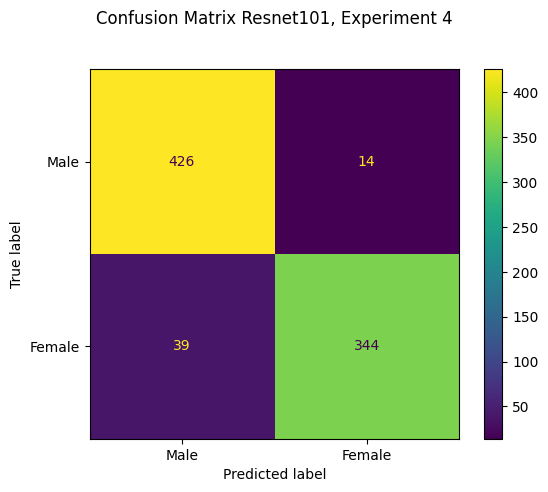

In [60]:
# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                display_labels= labels,
                                )
disp.plot(include_values=True, ax=None, xticks_rotation='horizontal')
plt.title('Confusion Matrix Resnet101, Experiment 4', y=1.1)
plt.savefig('Confusion_Experiment_4.jpg',
            dpi = 150, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Code Modif from Chat GPT

## 4.3. Evaluation Matrix

In [61]:
# Matriks Evaluasi

# Menghitung matriks confusion -> pada object 'cm_1' di atas

# Membuat laporan klasifikasi
target_names = ['Male', 'Female']  # Ganti dengan nama kelas yang sesuai
classification_rep = classification_report(test_df['Gender'], test_df['Prediction'],
                                            target_names=target_names, output_dict=True)

# Membuat DataFrame dari matriks confusion
df_confusion = pd.DataFrame(cm, columns=target_names, index=target_names)

# Membuat DataFrame dari laporan klasifikasi
df_classification = pd.DataFrame(classification_rep).transpose()

# Menampilkan tabel matriks evaluasi
print("Confusion Matrix:")
print(df_confusion)
print("\nClassification Report:")
print(df_classification)

# Code Modif from Chat GPT

Confusion Matrix:
        Male  Female
Male     426      14
Female    39     344

Classification Report:
              precision    recall  f1-score     support
Male           0.960894  0.898172  0.928475  383.000000
Female         0.916129  0.968182  0.941436  440.000000
accuracy       0.935601  0.935601  0.935601    0.935601
macro avg      0.938511  0.933177  0.934956  823.000000
weighted avg   0.936961  0.935601  0.935405  823.000000


In [62]:
# Matrix Evaluasi
print(classification_report(test_df['Gender'], test_df['Prediction'], target_names = ['Male', 'Female']))

# Code Modif from Chat GPT

              precision    recall  f1-score   support

        Male       0.96      0.90      0.93       383
      Female       0.92      0.97      0.94       440

    accuracy                           0.94       823
   macro avg       0.94      0.93      0.93       823
weighted avg       0.94      0.94      0.94       823



## 4.4. Showing Wrong Image Prediction of Male

In [63]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_woman_df = wrong_df[wrong_df['Gender'] == 'Male']
wrong_woman_df.head()

image_id  Male Gender Prediction
2486  037369.jpg     1   Male     Female
2633  008886.jpg     1   Male     Female
1534  128353.jpg     1   Male     Female
2799  066796.jpg     1   Male     Female
4300  089241.jpg     1   Male     Female

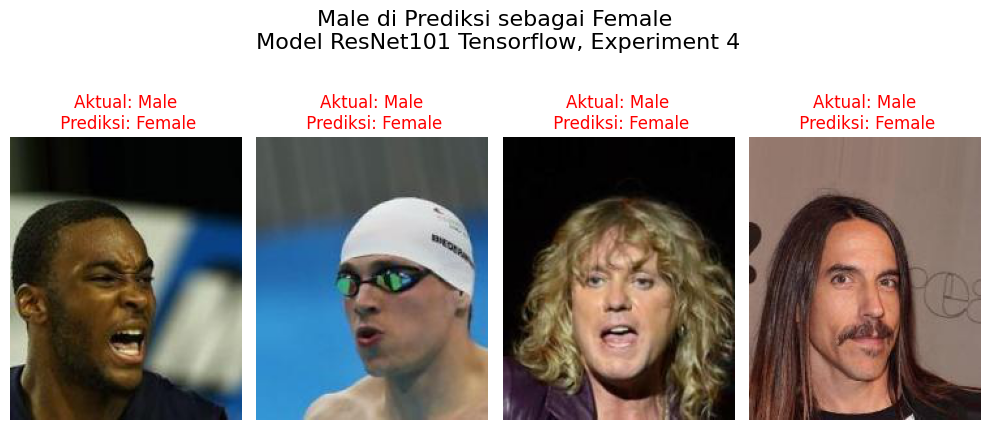

In [64]:
# Menampilkan Foto Male yang di Prediksi sebagai Female

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), wrong_woman_df.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']

    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Male di Prediksi sebagai Female\n Model ResNet101 Tensorflow, Experiment 4", size = 16)

    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('./Male_di_Prediksi_sebagai_Female_ResNet 101_Experiment.jpg', dpi=150)

# Code Modif dari Chat GPT

## 4.5. Showing Wrong Image Prediction of Female

In [65]:
# Menyiapkan Data yang Salah Prediksi
wrong_df = test_df[test_df['Gender'] != test_df['Prediction']]

# menyiapkan Data yang Male di Prediksi sebagai Female
wrong_male_df = wrong_df[wrong_df['Gender'] == 'Female']
wrong_male_df.head()

image_id  Male  Gender Prediction
2726  062523.jpg    -1  Female       Male
3188  119940.jpg    -1  Female       Male
1284  132053.jpg    -1  Female       Male
4711  034817.jpg    -1  Female       Male
1988  158942.jpg    -1  Female       Male

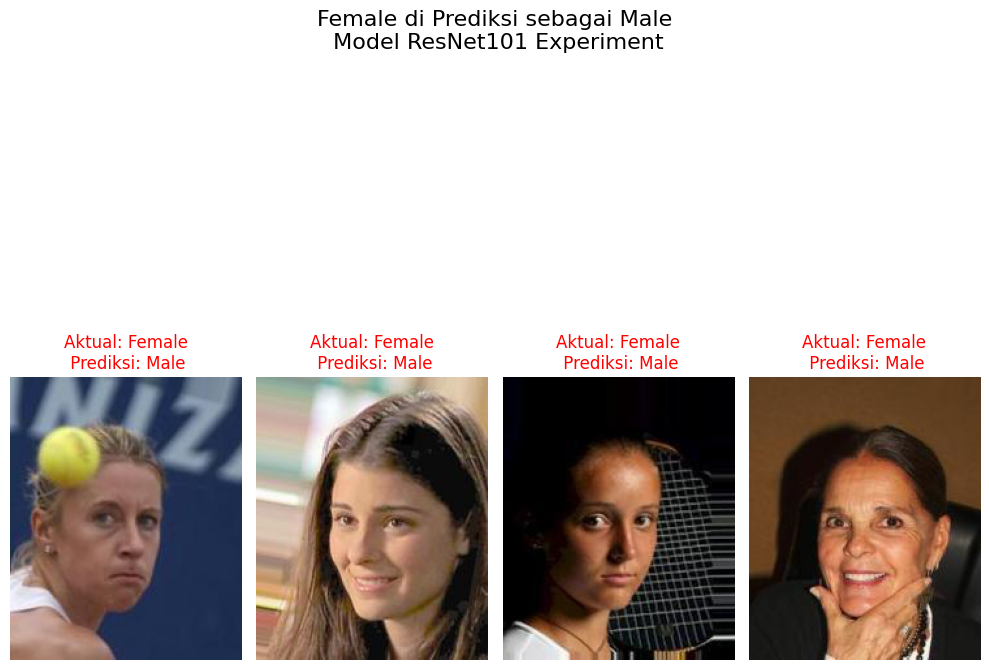

In [66]:
# Menampilkan Foto Female yang di Prediksi sebagai Male

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))

# Iterate over the data frame subset and subplot axes
for index, (ax, row) in enumerate(zip(axes.flatten(), wrong_male_df.iterrows())):
    # Get the image file name and corresponding value
    image_file = row[1]['image_id']
    value1 = row[1]['image_id']
    value2 = row[1]['Gender']
    value3 = row[1]['Prediction']

    # Read and plot the image
    image_path = os.path.join(IMG_PATH, image_file)
    image = plt.imread(image_path)
    ax.imshow(image)

    # Menambahkan judul dengan warna merah jika prediksi salah
    if value3 == value2:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='green')
    else:
        ax.set_title(f'Aktual: {value2}\n Prediksi: {value3}', color='red')

    plt.suptitle("Female di Prediksi sebagai Male\n Model ResNet101 Experiment", size = 16)

    # Remove the axis ticks and labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Menyimpan Foto Hasil Prediksi
fig.savefig('./Female_di_Prediksi_sebagai_Male_ResNet101_Experiment.jpg', dpi=150)

# Code Modif dari Chat GPT

# 5. Saving Model

In [ ]:
# Menyimpan Model Epoch terakhir
# vgg_model.save('./Model/Transfer ResNet101 TF FTuning ResNet101 Experiment.h5')

# 6. References

[CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/code)

[90%+ accuracy, gender_classification using VGG-16](https://www.kaggle.com/code/ashar88/90-accuracy-gender-classification-using-vgg-16)

[Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

[Starter: CelebFaces Attributes (CelebA) b5421ae1-e](https://www.kaggle.com/code/ky2019/starter-celebfaces-attributes-celeba-b5421ae1-e)

[Image Recognition - Gender Detection - Inception](https://www.kaggle.com/code/bmarcos/image-recognition-gender-detection-inceptionv3)

[Gender Classification (96% accuracy)](https://www.kaggle.com/code/dipeshmalhotra/gender-classification-96-accuracy)

[Gender Classification](https://www.kaggle.com/code/gerrygui/gender-classification/notebook)